In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict
from cemba_data.tools.integration.utilities import calculate_direct_confusion
from ALLCools.plot import *
from ALLCools.plot.color import plot_colorbar
import xarray as xr

In [2]:
from matplotlib import rc

labelsize = 6
linewidth = 0.6
rc('lines', linewidth=linewidth)
rc('axes', labelsize=labelsize, linewidth=linewidth)
rc('xtick', labelsize=labelsize)
rc('ytick', labelsize=labelsize)
rc('xtick.major', width=linewidth)
rc('ytick.major', width=linewidth)
rc('xtick.minor', width=linewidth-0.2)
rc('ytick.minor', width=linewidth-0.2)
rc('patch', linewidth=linewidth)

## Tidy data

In [3]:
cell_tidy_data = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/ClusteringSummary/Summary/TotalClusteringResults.msg'
)

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/dissection_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
sub_region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
major_region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/major_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()

cell_class_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/cell_class.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
major_type_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/major_type.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
sub_type_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_type.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()

for sub_type in cell_tidy_data['SubType'].unique():
    if sub_type not in sub_type_palette:
        # outlier and NA color
        sub_type_palette[sub_type] = '#D3D3D3'

## Dot plot

In [5]:
cell_tidy_data = cell_tidy_data[cell_tidy_data['MajorType'] == 'IG-CA2']
cell_tidy_data = cell_tidy_data[cell_tidy_data['SubType'].apply(lambda i: 'Outlier' not in i)].copy()

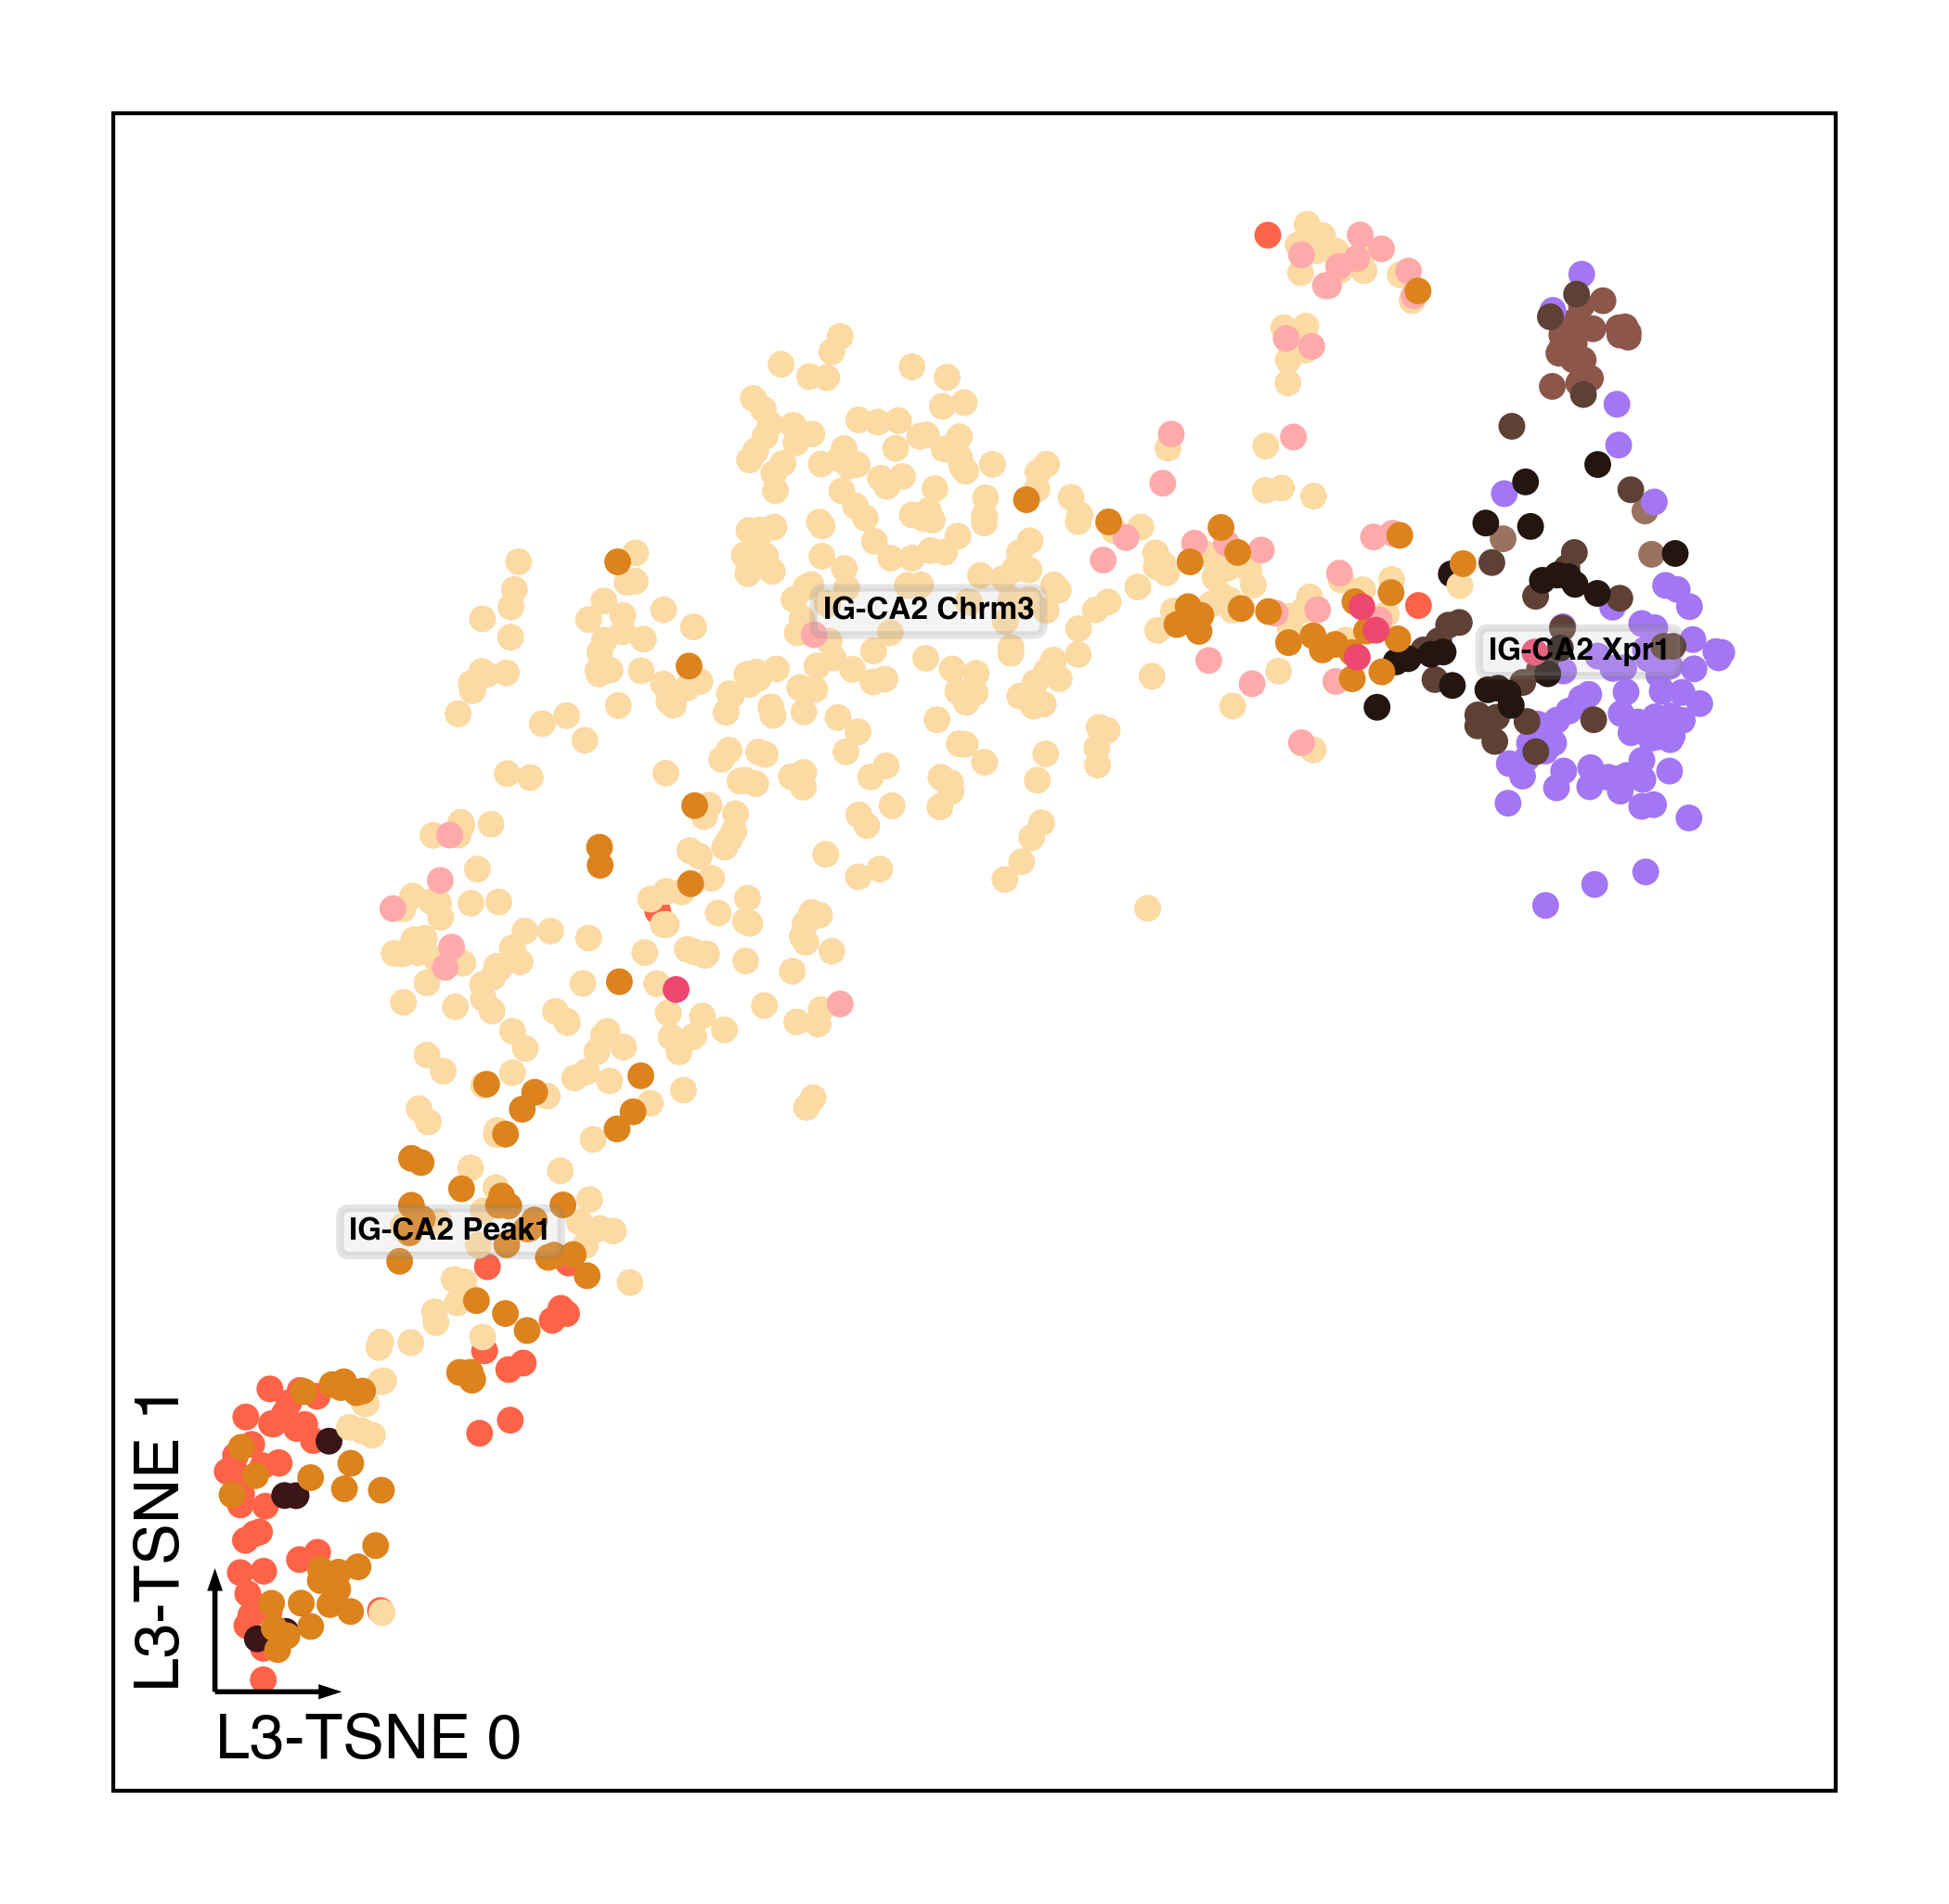

In [6]:
fig, ax = plt.subplots(figsize=(2, 2), dpi=1200)

categorical_scatter(ax=ax,
                    data=cell_tidy_data,
                    coord_base='l3-tsne',
                    hue='Region',
                    palette=region_palette,
                    s=3,
                    max_points=None,
                    text_anno='SubType', 
                    text_anno_kws=dict(fontsize=2))

add_ax_box(ax, linewidth=0.5)
pass

## Gene

In [7]:
# mcds = xr.open_mfdataset(
#     '/home/hanliu/project/mouse_rostral_brain/study/Level1-CellClass/ALL_manual/Adata/Select*mcds'
# )
# 
# mcds = mcds.sel(cell=cell_tidy_data.index)

mcds = xr.open_dataset('IG_CA2.genes.mcds').load()
mcds.load()

<xarray.Dataset>
Dimensions:      (cell: 745, gene: 55487, mc_type: 2)
Coordinates:
    strand_type  <U4 'both'
    gene_start   (gene) int64 3073252 3102015 3205900 ... 14144 15288 15355
    gene_end     (gene) int64 3074321 3102124 3671497 ... 15287 15354 15421
    gene_chrom   (gene) object 'chr1' 'chr1' 'chr1' ... 'chrM' 'chrM' 'chrM'
  * mc_type      (mc_type) object 'CGN' 'CHN'
  * gene         (gene) object 'ENSMUSG00000102693.1' ... 'ENSMUSG00000064372.1'
  * cell         (cell) object '10E_M_1513' '10E_M_1514' ... '9J_M_449'
Data variables:
    gene_da      (cell, gene, mc_type) float64 1.0 0.7618 1.0 ... 1.0 0.8285

## Gene meta

In [8]:
gene_meta = pd.read_csv(
    '/home/hanliu/ref/mouse/gencode/vm22/gencode.vM22.annotation.gene.flat.tsv.gz',
    index_col='gene_id',
    sep='\t')
gene_meta.index.name = 'gene'
gene_name_to_id = {v: k for k, v in gene_meta['gene_name'].iteritems()}
gene_idbase_to_id = {i.split('.')[0]: i for i in gene_meta.index}

In [9]:
def add_gene_data(gene):
    gene_id = gene_name_to_id[gene]
    gene_data = mcds.sel(gene=gene_id, mc_type='CHN')['gene_da'].to_pandas()
    cell_tidy_data[gene] = gene_data

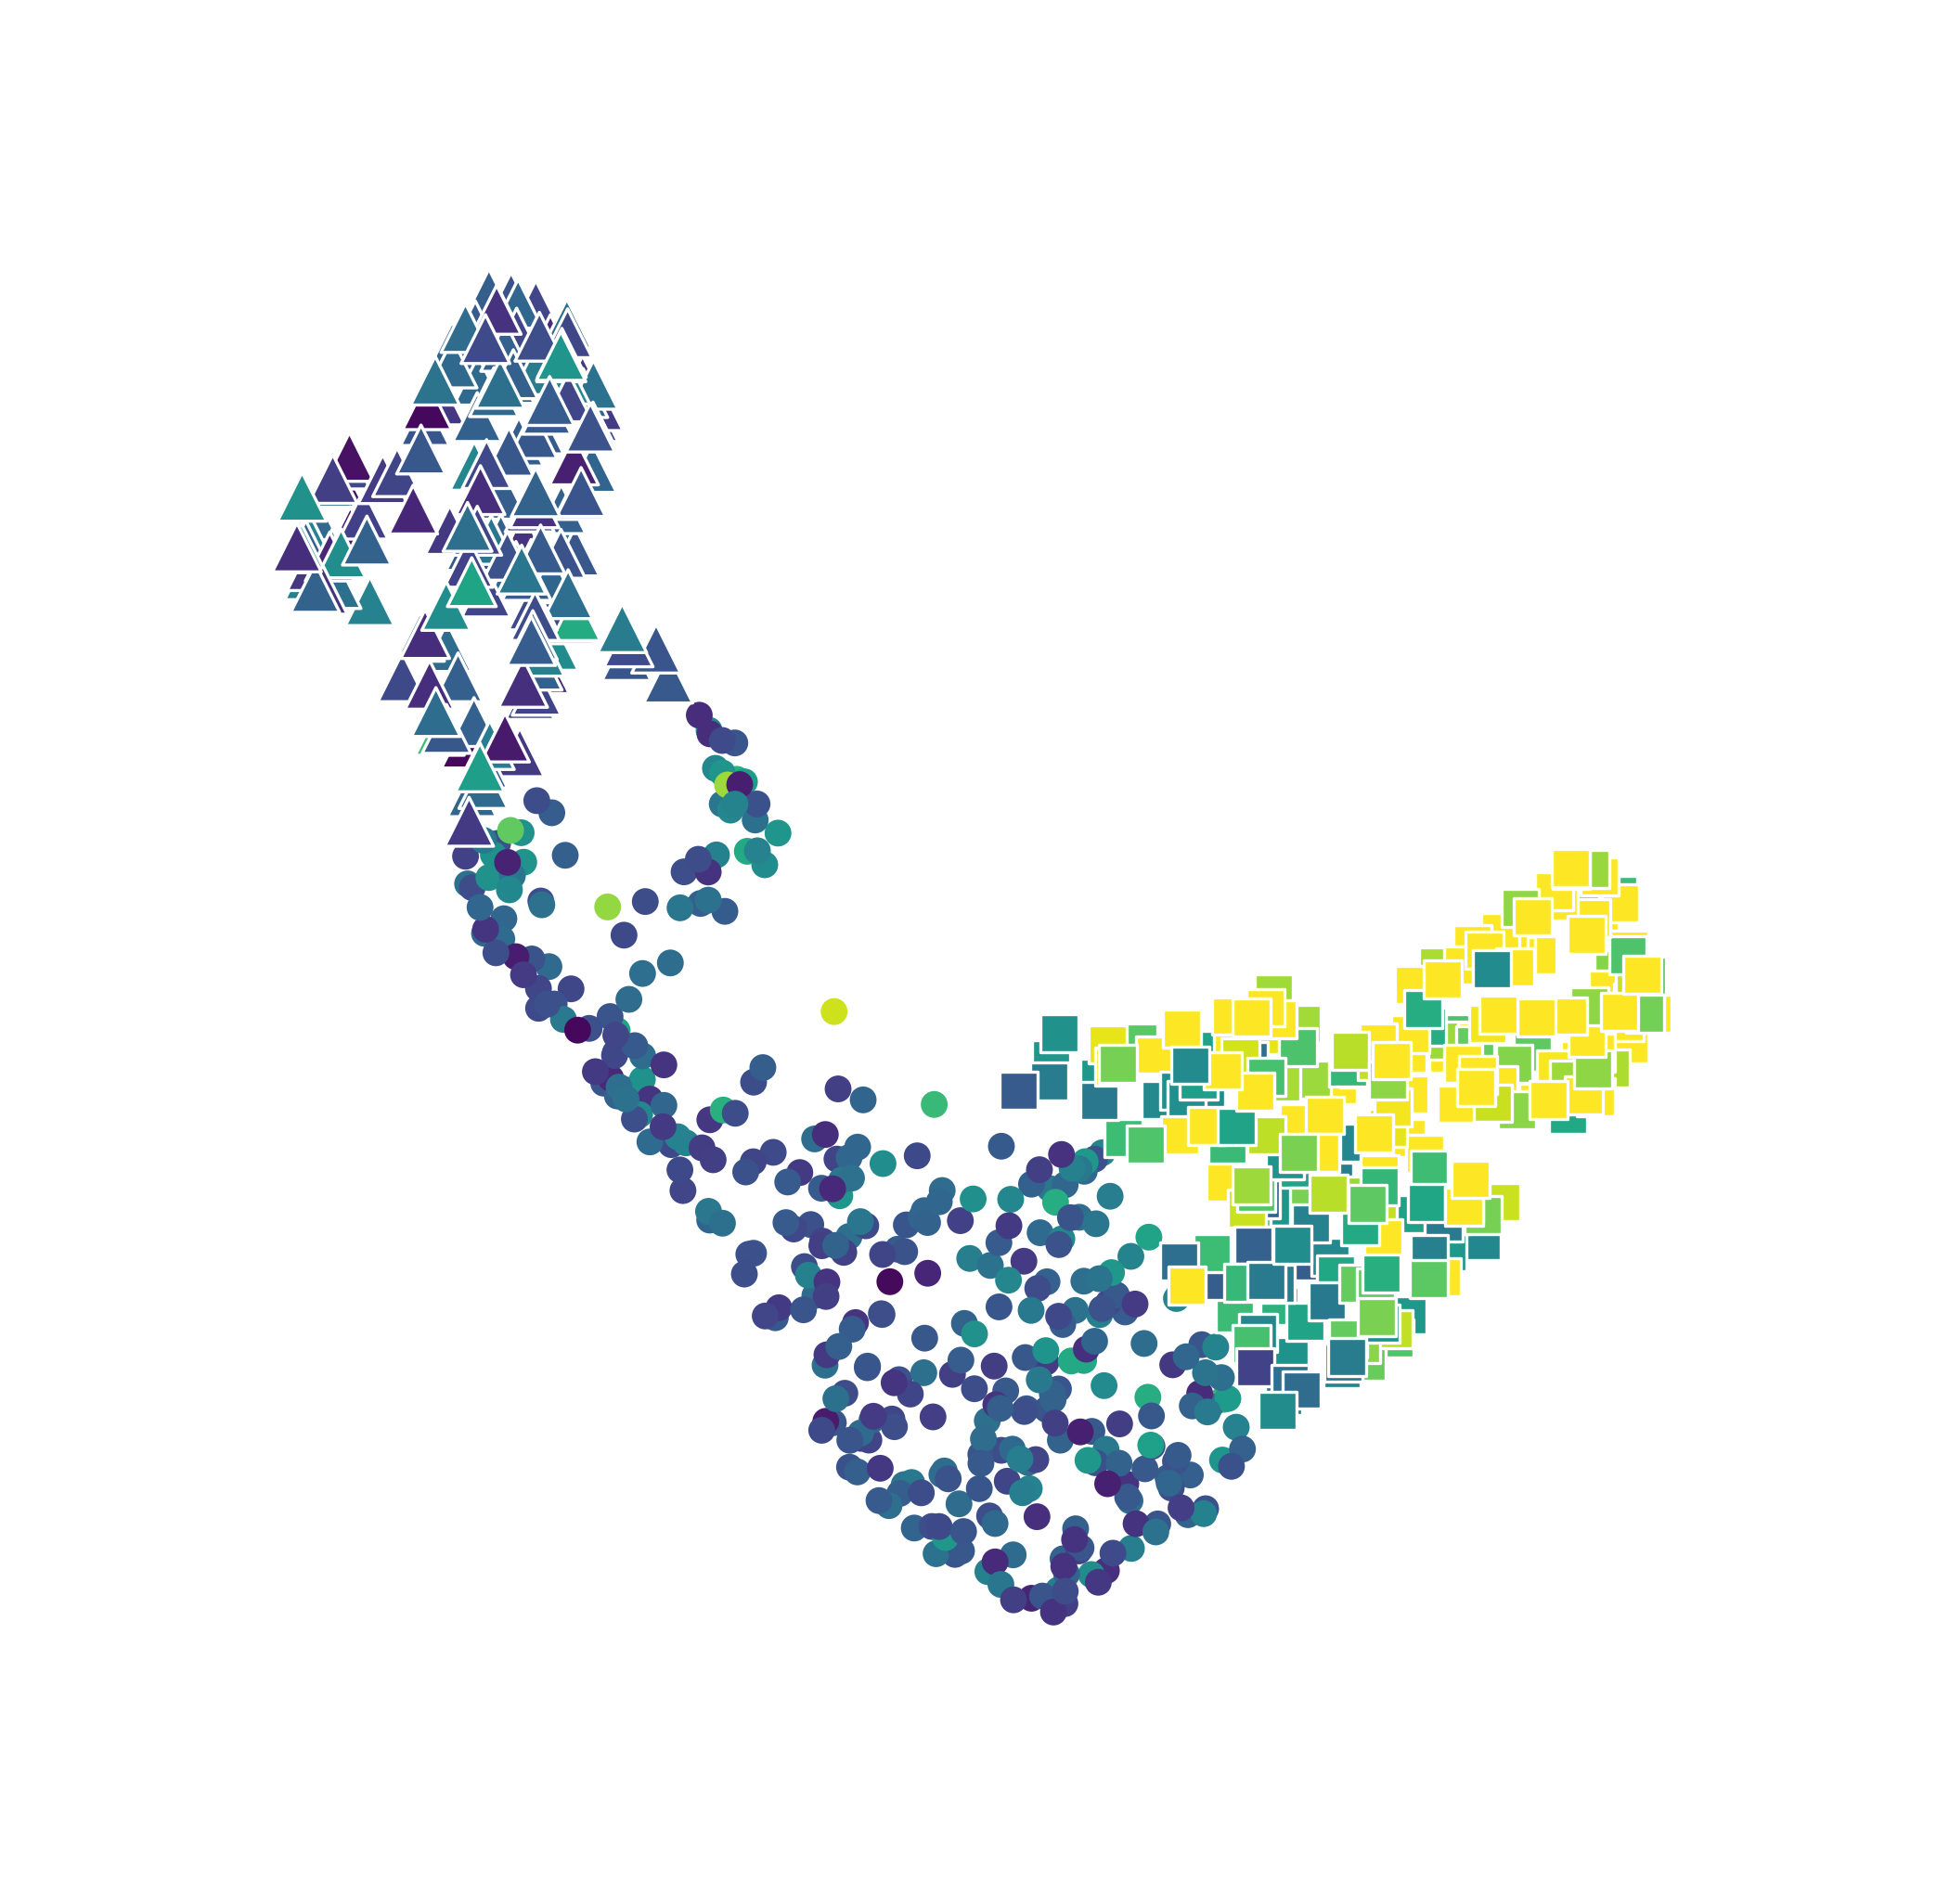

In [24]:
gene = 'Ntf3'

add_gene_data(gene=gene)

fig, ax = plt.subplots(figsize=(2, 2), dpi=1200)

continuous_scatter(
    ax=ax,
    data=cell_tidy_data[cell_tidy_data['SubType'] == 'IG-CA2 Chrm3'],
    coord_base='l3-umap',
    hue=gene,
    hue_norm=(0, 2),
    s=3,
    max_points=None,
    # text_anno='SubType',
    axis_format=None,
    text_anno_kws=dict(fontsize=2), colorbar=False)
continuous_scatter(
    ax=ax,
    data=cell_tidy_data[cell_tidy_data['SubType'] == 'IG-CA2 Xpr1'],
    coord_base='l3-umap',
    hue=gene,
    hue_norm=(0, 2),
    s=10,
    scatter_kws=dict(linewidth=0.2, marker='^'),
    max_points=None,
    # text_anno='SubType',
    axis_format=None,
    text_anno_kws=dict(fontsize=2), colorbar=False)
continuous_scatter(
    ax=ax,
    data=cell_tidy_data[cell_tidy_data['SubType'] == 'IG-CA2 Peak1'],
    coord_base='l3-umap',
    hue=gene,
    hue_norm=(0, 2),
    s=6,
    scatter_kws=dict(linewidth=0.2, marker='s'),
    max_points=None,
    # text_anno='SubType',
    axis_format=None,
    text_anno_kws=dict(fontsize=2), colorbar=False)

ax.set_xlim(-15.89, 8.33)
ax.set_ylim(-3.27, 14.1)
    
fig.savefig(f'UMAP-IG-CA2_{gene}_mCH.scatter_part.png')

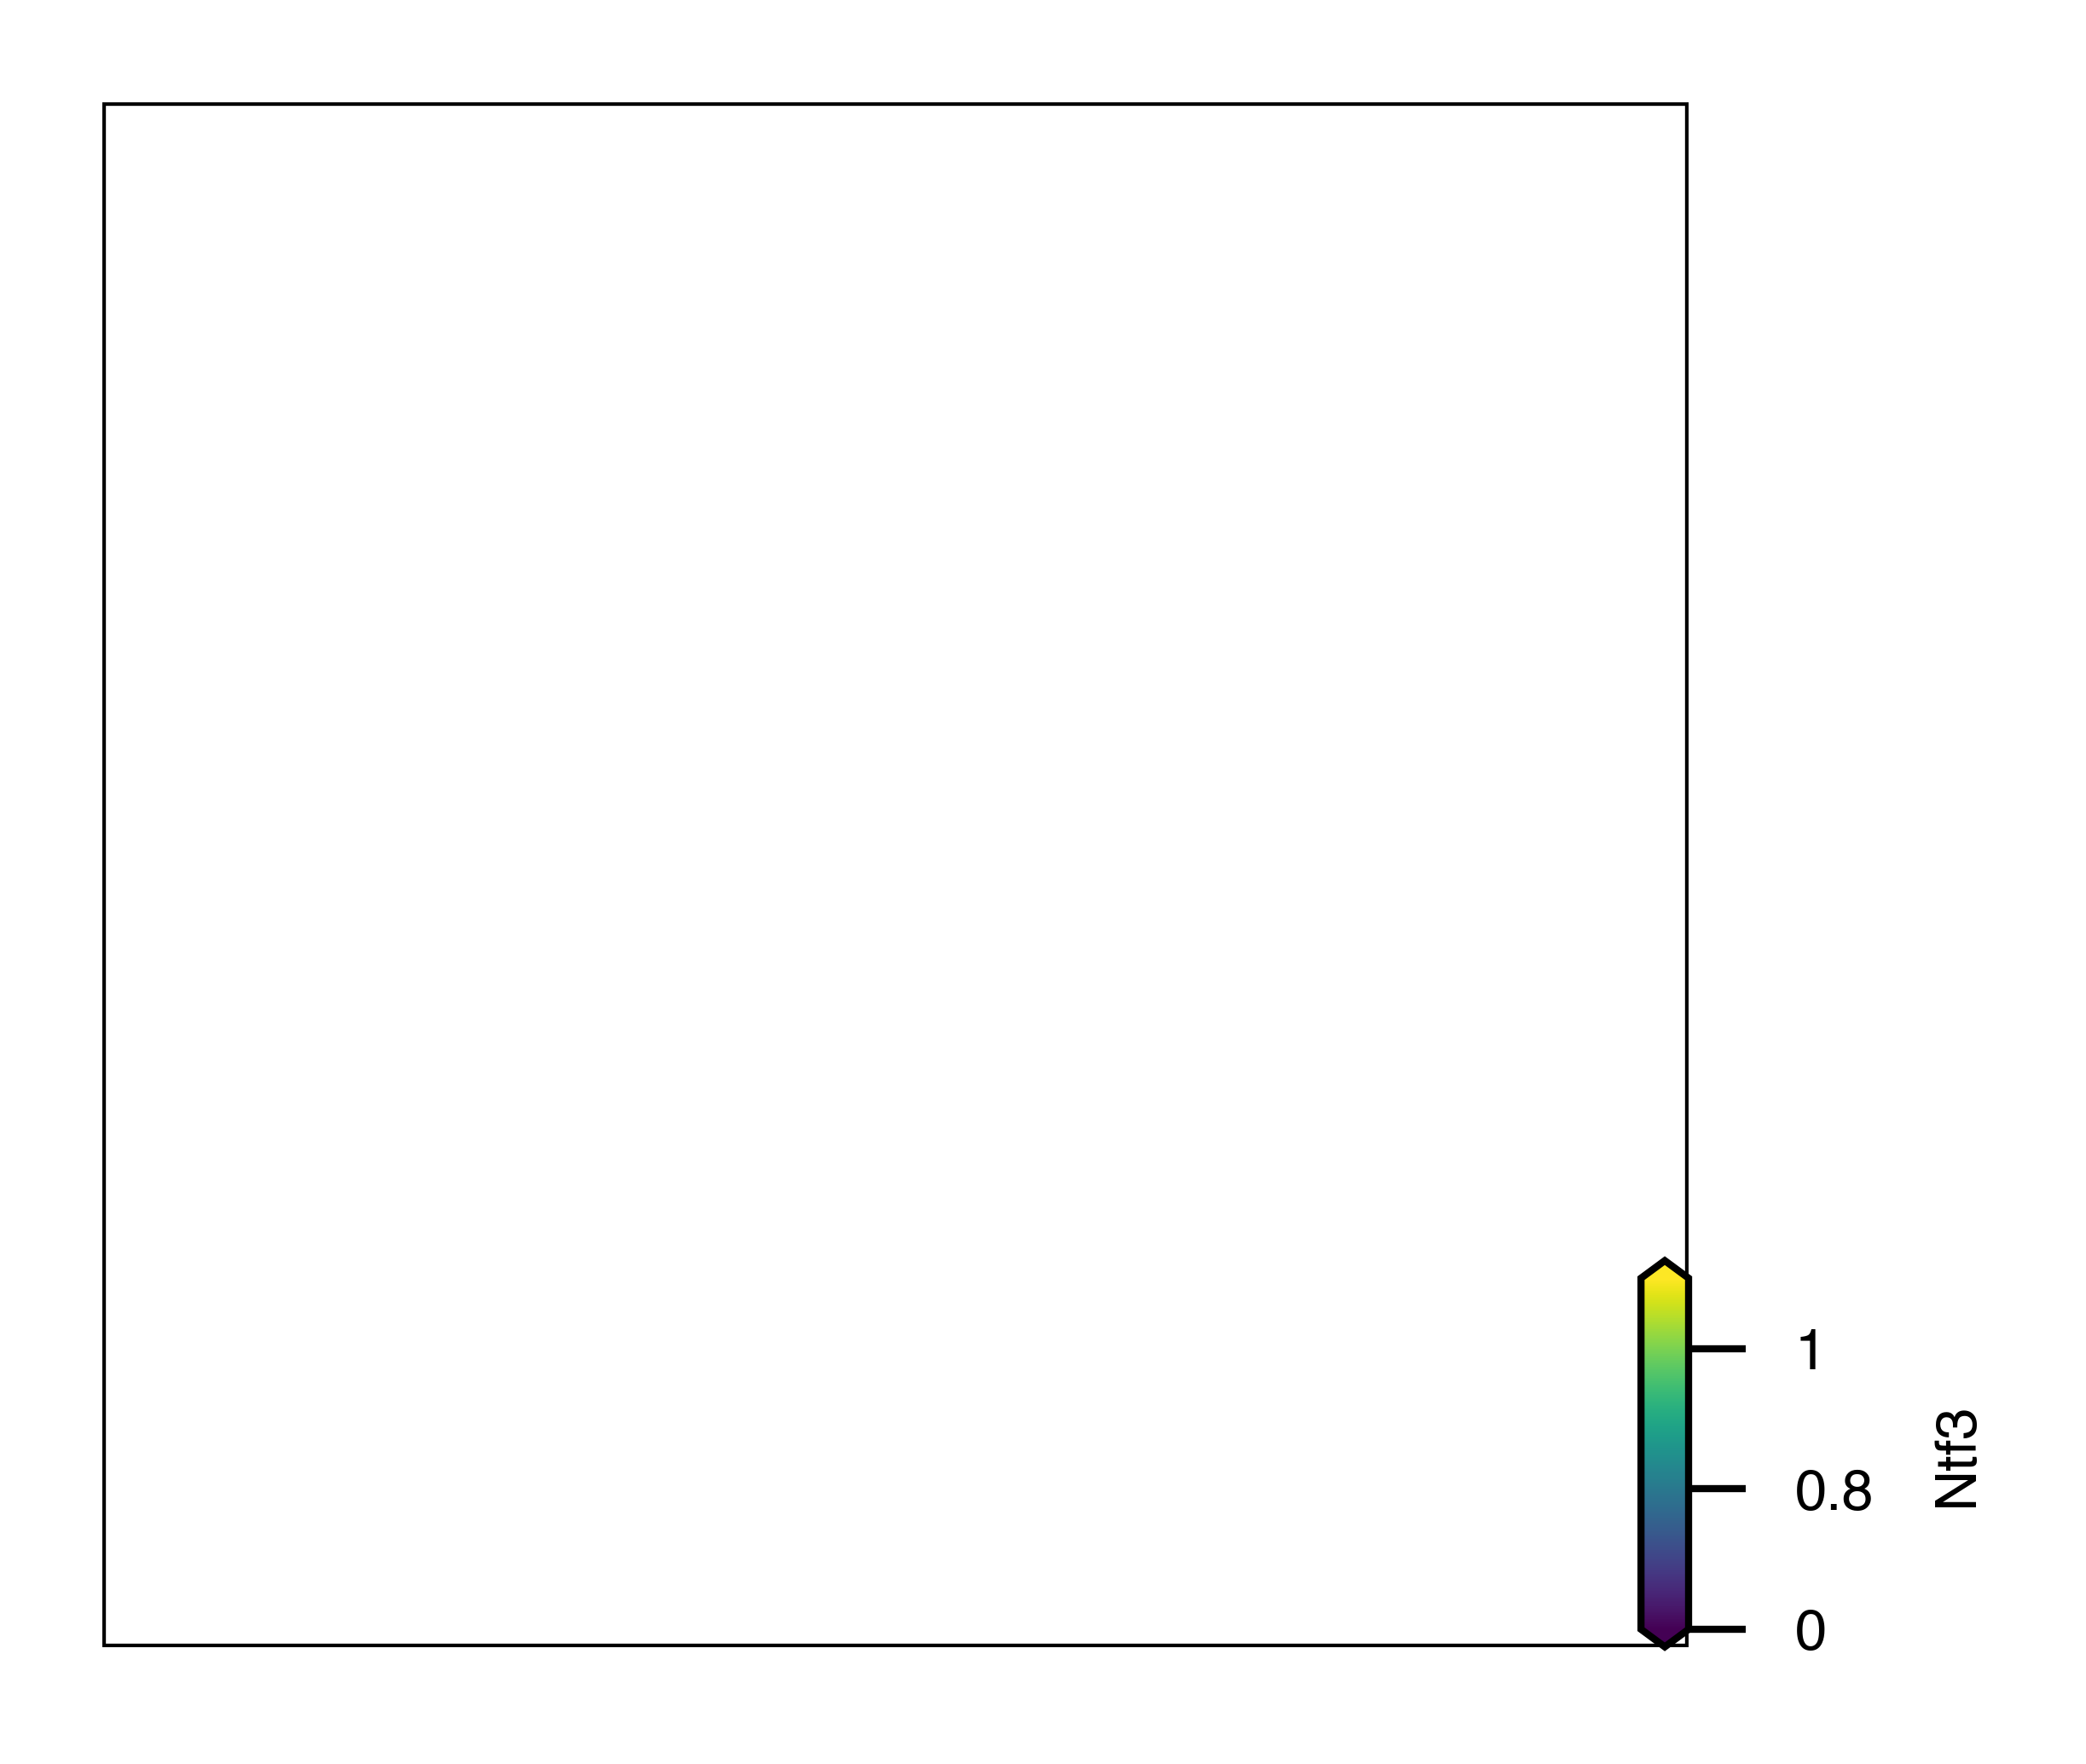

In [11]:
add_gene_data(gene=gene)

fig, ax = plt.subplots(figsize=(2, 2), dpi=1200)

continuous_scatter(
    ax=ax,
    data=cell_tidy_data[cell_tidy_data['SubType'] == 'IG-CA2 Chrm3'],
    coord_base='l3-umap',
    hue=gene,
    hue_norm=(0, 2),
    s=3,
    max_points=None,
    # text_anno='SubType',
    axis_format=None,
    text_anno_kws=dict(fontsize=2))
continuous_scatter(
    ax=ax,
    data=cell_tidy_data[cell_tidy_data['SubType'] == 'IG-CA2 Xpr1'],
    coord_base='l3-umap',
    hue=gene,
    hue_norm=(0, 2),
    s=10,
    scatter_kws=dict(linewidth=0.2, marker='^'),
    max_points=None,
    # text_anno='SubType',
    axis_format=None,
    text_anno_kws=dict(fontsize=2), colorbar=False)
continuous_scatter(
    ax=ax,
    data=cell_tidy_data[cell_tidy_data['SubType'] == 'IG-CA2 Peak1'],
    coord_base='l3-umap',
    hue=gene,
    hue_norm=(0, 2),
    s=6,
    scatter_kws=dict(linewidth=0.2, marker='s'),
    max_points=None,
    # text_anno='SubType',
    axis_format=None,
    text_anno_kws=dict(fontsize=2), colorbar=False)

ax.set_xlim(-15.89, 8.33)
ax.set_ylim(-3.27, 14.1)
add_ax_box(ax, linewidth=0.5)
ax.collections[0].remove()
ax.collections[0].remove()
ax.collections[0].remove()
    
fig.savefig('UMAP-IG-CA2_Ntf3_mCH.label_part.pdf')